In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from statsmodels.stats.multitest import fdrcorrection

In [2]:
feature_names = json.loads(open('utils/lut_dict.txt').read())

In [3]:
for feature in feature_names.keys():
    if 'area' in feature:
        feature_names[feature] = feature_names[feature] + " A"
    elif 'thickness' in feature:
        feature_names[feature] = feature_names[feature] + " T"
    else:
        feature_names[feature] = feature_names[feature]  

In [4]:
# HISTOGRAM
#############################################################

# create dataframes
important_features = pd.read_csv("out/important_features.csv")
ml_dataframe = pd.read_csv("stats/ml_dataframe.csv")
print(ml_dataframe.shape)
ml_dataframe = ml_dataframe.dropna(axis=0)
print(ml_dataframe.shape)

# rename columns 
important_features = important_features.rename(columns={'feature': 'importance'})
important_features = important_features.rename(columns={'Unnamed: 0': 'feature'})

# print all important features into a new list
important_features_list = important_features['feature'].tolist()

# save names of features where importance >=5 to a list called top_features
top_features = important_features[important_features['importance'] >= 5]
top_features = top_features['feature'].tolist()

# make separate dataframe for top features' importance 
top_features_importance = important_features[important_features['importance'] >= 5]

# reading LUT
region_names = np.array(list([feature_names[feature] for feature in important_features['feature']]))

# add label column
important_features['feature type'] = np.where(important_features['feature'].str.contains('thickness'), "thickness", 
                                       np.where(important_features['feature'].str.contains('area'), "area", "volume"))
important_features['feature'] = region_names

(152, 421)
(152, 421)


In [ ]:
# # generate histogram
# with plt.xkcd():
#     ax1 = sns.catplot(data=important_features, kind="bar", x="importance", y="feature", height=15, aspect=2, hue="feature type", dodge=False, palette=['#5Ef2A8', '#6E8CE3', '#FF9F21'])
#     plt.xticks([0,1,2,3,4,5,6,7,8,9,10])    
#     plt.title("Feature Importance", fontsize=40)
#     plt.xlabel("Importance", fontsize=30)
#     plt.ylabel("Feature", fontsize=30)
#     plt.savefig('out/important_features.png', dpi=300, bbox_inches='tight')
#     plt.clf()

In [5]:
# FEATURE WEIGHTS
#############################################################

# make a graph to visualize the feature weights data in outs folder ([fold]_feature_weights.csv)
#load df from all folds and merge into one dataframe

#create new dataframe for each fold file

dataframes = []  # List to store the dataframes

for i in range(0,10):
    filename=('out/{}_feature_weights.csv'.format(i))
     # Generate the filename
    df = pd.read_csv(filename)  # Read the CSV file into a dataframe
    dataframes.append(df)

# rename first column of each dataframe to fold #
for i in range(0,10):
    dataframes[i] = dataframes[i].rename(columns={'Unnamed: 0': 'fold #'})
    dataframes[i]['fold #'] = i

# merge all 10 dataframes within dataframes list into a single dataframe
all_weights = pd.concat(dataframes)
all_weights.head()

,fold #,rh_G_temp_sup-G_T_transv_area,lh_S_circular_insula_inf_thickness,rh_S_circular_insula_inf_thickness,rh_S_front_sup_area,lh_G_rectus_thickness,rh_VM,rh_PuM,lh_S_pericallosal_area,lh_PuI,...,lh_G_temp_sup-Lateral_area,rh_G_cuneus_area,rh_S_temporal_sup_area,lh_G_front_inf-Orbital_area,rh_MGN,lh_AV,rh_Pole_temporal_area,rh_S_orbital-H_Shaped_area,lh_S_collat_transv_post_area,lh_HATA
0,0,-0.071184,-0.072614,-0.108120,0.100331,0.204653,-0.491208,-0.156778,0.108842,0.139625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,NaN,NaN,NaN,NaN,NaN,-0.388743,NaN,0.187188,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2,-0.053031,-0.054735,-0.091603,0.133508,0.150992,-0.350524,NaN,0.132780,0.122341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3,NaN,-0.079293,NaN,0.062400,NaN,-0.413438,-0.147736,0.174252,0.115615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4,NaN,-0.066225,-0.074286,0.132953,0.210409,-0.416574,NaN,0.228738,0.135578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# melt
all_weights = pd.melt(all_weights, id_vars=['fold #'], var_name='feature', value_name='weight')
print(all_weights)

     fold #                        feature    weight
0         0  rh_G_temp_sup-G_T_transv_area -0.071184
1         1  rh_G_temp_sup-G_T_transv_area       NaN
2         2  rh_G_temp_sup-G_T_transv_area -0.053031
3         3  rh_G_temp_sup-G_T_transv_area       NaN
4         4  rh_G_temp_sup-G_T_transv_area       NaN
..      ...                            ...       ...
615       5                        lh_HATA       NaN
616       6                        lh_HATA       NaN
617       7                        lh_HATA       NaN
618       8                        lh_HATA       NaN
619       9                        lh_HATA -0.084661

[620 rows x 3 columns]


In [ ]:
print(important_features)



In [7]:
# make top_weights dataframe where feature is in top_features list
top_weights = all_weights[all_weights['feature'].isin(top_features)]

# abbreviate names
region_names = np.array(list([feature_names[feature] for feature in top_weights['feature']]))
top_weights['feature'] = region_names

#do same for top_features_importance
region_names = np.array(list([feature_names[feature] for feature in top_features_importance['feature']]))
top_features_importance['feature'] = region_names

# add 'importance' column to top_weights datafram where the importance is the importance of that feature based on 'importance' from top_features_importance
top_weights['importance'] = top_weights['feature'].map(top_features_importance.set_index('feature')['importance'])


# abs value
top_weights['weight'] = top_weights['weight'].abs()
top_weights

/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_86004/393470608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_weights['feature'] = region_names
/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_86004/393470608.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_importance['feature'] = region_names
/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_86004/393470608.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,fold #,feature,weight,importance
0,0,R HG A,0.071184,6
1,1,R HG A,NaN,6
2,2,R HG A,0.053031,6
3,3,R HG A,NaN,6
4,4,R HG A,NaN,6
...,...,...,...,...
315,5,L PerCaS T,0.149703,5
316,6,L PerCaS T,0.086525,5
317,7,L PerCaS T,0.101005,5
318,8,L PerCaS T,NaN,5


In [ ]:
# print(top_weights['feature'])
# # palette_dict = {'R VM V': '#E0F9E9', 'L PerCaS A': '#C8E6C9', 'R PosCG A': '#50fa97', 'R SupFS A': '#50fa97',
# #                 'L RG T': '#ffad33', 'R L-Sg V': '#70e0ff', 'L TOS A': '#50fa97', 'R HG A': '#50fa97',
# #                 'L InfCrInS T': '#ffad33', 'L PuI V': '#70e0ff', 'R CA3 Body V': '#70e0ff', 'L VPL V': '#70e0ff',
# #                 'R FuG A': '#50fa97', 'R MDm V': '#70e0ff','L PerCaS T': '#ffad33', 'R InfCrInS T': '#ffad33', 
# #                 'R Cun T': '#ffad33'}

# # palette_dict = {'R VM V': '#70e0ff', 'L PerCaS A': '#70e0ff', 'R PosCG A': '#50fa97', 'R SupFS A': '#50fa97',
# #                 'L RG T': '#ffad33', 'R L-Sg V': '#70e0ff', 'L TOS A': '#50fa97', 'R HG A': '#50fa97',
# #                 'L InfCrInS T': '#ffad33', 'L PuI V': '#70e0ff', 'R CA3 Body V': '#70e0ff', 'L VPL V': '#70e0ff',
# #                 'R FuG A': '#50fa97', 'R MDm V': '#70e0ff','L PerCaS T': '#ffad33', 'R InfCrInS T': '#ffad33', 
# #                 'R Cun T': '#ffad33'}

# palette_dict = {'R VM V': '#70e0ff', 'L PerCaS A': '#50fa97', 'R PosCG A': '#50fa97', 'R SupFS A': '#50fa97',
#                 'L RG T': '#ffad33', 'R L-Sg V': '#70e0ff', 'L TOS A': '#50fa97', 'R HG A': '#50fa97',
#                 'L InfCrInS T': '#ffad33', 'L PuI V': '#70e0ff', 'R CA3 Body V': '#70e0ff', 'L VPL V': '#70e0ff',
#                 'R FuG A': '#50fa97', 'R MDm V': '#70e0ff','L PerCaS T': '#ffad33', 'R InfCrInS T': '#ffad33', 
#                 'R Cun T': '#ffad33'}
# #V T V T V A V V V A T A A T T A A
# print(palette_dict)

# top_weights['feature'].unique()

In [8]:
# make new column w last character of feature
top_weights['type']=top_weights['feature'].str[-1]
top_weights['feature'].unique()

/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_86004/3137058948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_weights['type']=top_weights['feature'].str[-1]


array(['R HG A', 'L InfCrInS T', 'R InfCrInS T', 'R SupFS A', 'L RG T',
       'R VM V', 'L PerCaS A', 'L PuI V', 'R L-Sg V', 'L TOS A',
       'R Cun T', 'R PosCG A', 'R FuG A', 'L VPL V', 'R CA3 Body V',
       'R MDm V', 'L PerCaS T'], dtype=object)

In [9]:
means = []
print(top_features)
for i, _ in  enumerate(top_features):
    means.append((top_weights.groupby('feature').max().sort_values('weight', ascending=False)['weight'][i]))

print(means)

['rh_VM', 'lh_S_pericallosal_area', 'rh_G_postcentral_area', 'rh_S_front_sup_area', 'lh_G_rectus_thickness', 'rh_L-Sg', 'lh_S_oc_sup&transversal_area', 'rh_G_temp_sup-G_T_transv_area', 'lh_S_circular_insula_inf_thickness', 'lh_PuI', 'rh_CA3-body', 'lh_VPL', 'rh_G_oc-temp_lat-fusifor_area', 'rh_MDm', 'lh_S_pericallosal_thickness', 'rh_S_circular_insula_inf_thickness', 'rh_G_cuneus_thickness']
[0.4912076836070768, 0.3109376436048891, 0.231814063460381, 0.2287375173092509, 0.2104089591135308, 0.1977882526134461, 0.1912069752112344, 0.1697430187577147, 0.1656141199872517, 0.1613074930539552, 0.1564878395249868, 0.1335075939482546, 0.1212129365342661, 0.1195035899951841, 0.0792927996173565, 0.0787044300681327, 0.039872997677488]


In [10]:
values = []

# iterate over all rows in the top_weights dataframe
for index, row in top_weights.iterrows():
    if row['feature'] == "R VM V":
        values.append(row['weight'])

# remove nans
values = [x for x in values if str(x) != 'nan']
mean = sum(values) / len(values)
print(mean)

print(values)

0.41153131518674
[0.4912076836070768, 0.3887428098643458, 0.3505236198930426, 0.4134375500376277, 0.4165742364844436, 0.4720215234819801, 0.3667475626789379, 0.3884282122099242, 0.4487069115434637, 0.3789230420665573]


In [ ]:
top_regions = important_features[important_features['importance'] >= 5]
top_regions

In [377]:
xlabels = top_weights.groupby('feature').mean().sort_values('weight', ascending=False)

xlabels_list = xlabels.index.tolist()
xlabels_list_abbrev = [x[:-2] for x in xlabels_list]
xlabels_means = xlabels['weight'].tolist()
print(xlabels_list)
print(xlabels_means)

['R VM V', 'R Cun T', 'L VPL V', 'L RG T', 'R CA3 Body V', 'L PerCaS A', 'R MDm V', 'L PuI V', 'R L-Sg V', 'L TOS A', 'L PerCaS T', 'R SupFS A', 'R PosCG A', 'R InfCrInS T', 'L InfCrInS T', 'R HG A', 'R FuG A']
[0.41153131518674, 0.2628116175732598, 0.20341099207337657, 0.18952813246006425, 0.17483567677742054, 0.16991881000908796, 0.15262948599009563, 0.13501529073696858, 0.13489713674029516, 0.13357691623261578, 0.12669111117630555, 0.10038397546130459, 0.09348468936947324, 0.09138727325193709, 0.06629652687147514, 0.0653022742372136, 0.026029287984673216]


/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_57620/3617941031.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  xlabels = top_weights.groupby('feature').mean().sort_values('weight', ascending=False)


/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_57620/1039810035.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  whiskerprops={"color": "gray"}, capprops={"color": "gray"}, order=top_weights.groupby('feature').mean()
/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_57620/1039810035.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean().sort_values('weight', ascending=False).index)
/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_57620/1039810035.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeri

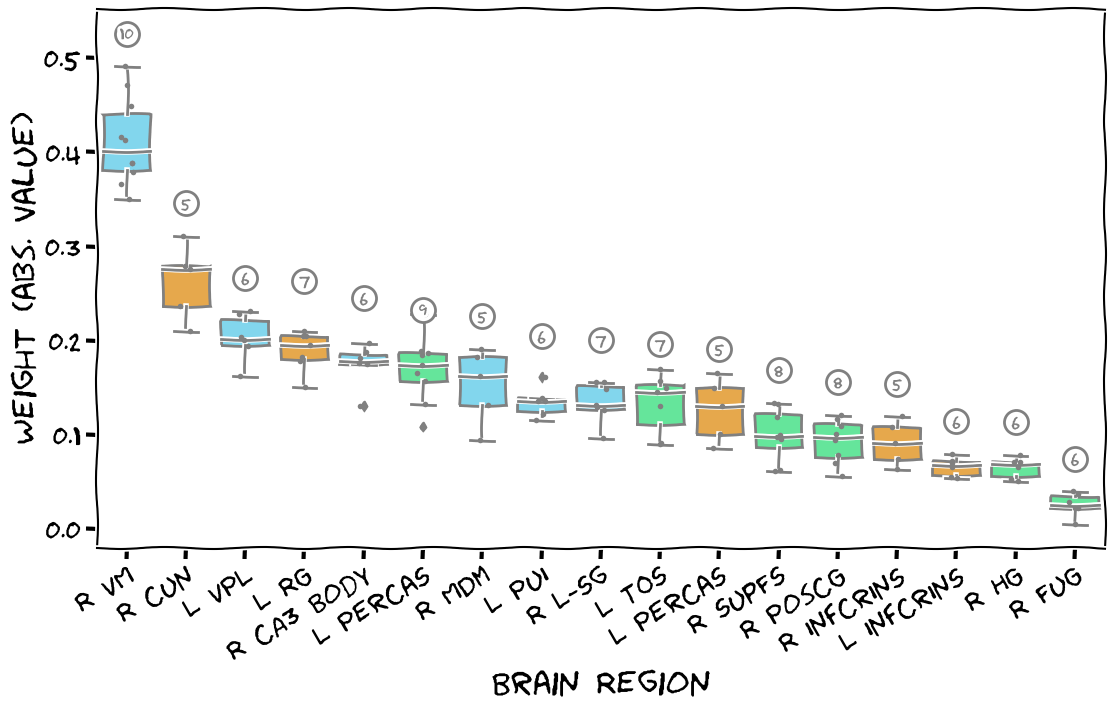

In [392]:
fig = plt.figure(figsize=(13,7))

with plt.xkcd():

    # boxplot
    ax=sns.boxplot(data=top_weights, x="feature", y="weight", palette=palette_dict, boxprops={'edgecolor':'gray'},  
                   flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, 
                   whiskerprops={"color": "gray"}, capprops={"color": "gray"}, order=top_weights.groupby('feature').mean()
                   .sort_values('weight', ascending=False).index)
    

    # add stripplot
    sns.stripplot(data=top_weights, x="feature", y="weight", color="gray", size=4, order=top_weights.groupby('feature')
                  .mean().sort_values('weight', ascending=False).index)
    

    # save axis labels and means in separate list
    xlabels = top_weights.groupby('feature').mean().sort_values('weight', ascending=False)
    xlabels_list = xlabels.index.tolist()
    xlabels_list_abbrev = [x[:-2] for x in xlabels_list]
    xlabels_means = xlabels['weight'].tolist()

    xlabels_importance = [10, 5, 6, 7, 6, 9, 5, 6, 7, 7, 5, 8, 8, 5, 6, 6, 6]

    plt.xticks(rotation=30,size=20,rotation_mode="anchor", ha="right", labels=xlabels_list_abbrev, ticks=np.arange(0, len(xlabels), 1))
    plt.yticks(size=20)

    plt.xlabel('Brain Region', size=24)
    plt.ylabel('Weight (abs. value)', size=24)


    # max weight of each feature
    xlabels_max = top_weights.groupby('feature').max().sort_values('weight', ascending=False)
    max_weights = []
    for index, row in xlabels_max.iterrows():
        max_weights.append(row['weight'])


    # fold labels

    for i,_ in enumerate(max_weights):
        plt.text(x=i, y=(max_weights[i]+0.03), s=xlabels_importance[i], color='gray', ha="center", fontsize=12)
        plt.scatter(x=i, y=(max_weights[i]+0.035), s=300, color='white', zorder=2, edgecolor='gray', linewidth=2)




plt.savefig('out/feature_weights.png', dpi=300, bbox_inches='tight')


In [391]:
# boxplot of the dataframe where y=weight and x=feature

fig = plt.figure(figsize=(13, 7))
with plt.xkcd():
    # ax = sns.boxplot(data=top_weights, x="feature", y="weight", orient="v", hue="type", palette="pastel", dodge=False, order=top_weights.groupby('feature').mean()
    #             .sort_values('weight', ascending=False).index)
    ax = sns.boxplot(data=top_weights, x="feature", y="weight", orient="v", palette=palette_dict, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"}, dodge=False, order=top_weights.groupby('feature').mean()
                .sort_values('weight', ascending=False).index)
    # x-axis labels 
    xlabels = top_weights.groupby('feature').mean().sort_values('weight', ascending=False).index.tolist()
    # top_features_importance = top_features_importance.set_index('feature').loc[xlabels].reset_index()

    # store means of boxplot in a list
    # means = []
    # for i, _ in  enumerate(top_features):
    #     means.append((top_weights.groupby('feature').max().sort_values('weight', ascending=False)['weight'][i]))

    plt.xlabel('Brain Region', size=24)
    plt.ylabel('Weight (abs. value)', size=24)

    plt.xticks(rotation=30, size=20, rotation_mode="anchor", ha="right",labels=top_regions['feature'].str[:-2], ticks=np.arange(0, len(top_regions['feature'].str[:-2]), 1))
    plt.yticks(size=20)
    sns.stripplot(data=top_weights, x="feature", y="weight", color="gray", zorder=1, size=4, jitter=0.2, dodge=True, order=top_weights.groupby('feature')
                .mean().sort_values('weight', ascending=False).index)

    # # add text labels corresponding to top_features_importance at each of the means
    # for i,_ in enumerate(top_features):
    #     plt.text(x=i, y=(means[i]+0.03), s=top_features_importance['importance'][i], color='gray', ha="center", fontsize=12)
    #     plt.scatter(x=i, y=(means[i]+0.035), s=300, color='white', zorder=2, edgecolor='gray', linewidth=2)
    # plt.savefig('out/feature_weights.png', dpi=300, bbox_inches='tight')
    plt.clf()

/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_57620/3069500867.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = sns.boxplot(data=top_weights, x="feature", y="weight", orient="v", palette=palette_dict, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"}, dodge=False, order=top_weights.groupby('feature').mean()
/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_57620/3069500867.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  xlabels = top_wei

<Figure size 1300x700 with 0 Axes>

In [11]:
# T-TEST
#############################################################

# create dataframe with only top features
top_features_dataframe = ml_dataframe[top_features]
top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']

# calculate mean for each column and put in list
means = []
for i, _ in enumerate(top_features):
    means.append(top_features_dataframe.mean()[top_features[i]])

# melt and organize dataframe for top features
top_features_dataframe = top_features_dataframe.melt(id_vars=['diagnosis'], var_name='feature', value_name='value').fillna(0)
top_features_dataframe['feature'] = [feature_names[feature] for feature in top_features_dataframe['feature']]

# # create and melt dataframe for all important features
# important_features_dataframe = ml_dataframe[important_features_list]
# important_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']
# important_features_dataframe = important_features_dataframe.melt(id_vars=['diagnosis'], var_name='feature', value_name='value').fillna(0)
# important_features_dataframe['feature'] = [feature_names[feature] for feature in important_features_dataframe['feature']]

# set up groups for t-test
ms_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS']
ms_tn_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS-TN']

/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_86004/296247506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']
/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_86004/296247506.py:11: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  means.append(top_features_dataframe.mean()[top_features[i]])
/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_86004/296247506.py:11: FutureWarning: The default value of numeric_only in DataFrame.

In [12]:
# run t-test

p_vals = []
p_corrected = []
stats_vals = []

# running t-test on top features
for feature in top_features:
    input_ms = ms_dataframe[feature]
    input_ms_tn = ms_tn_dataframe[feature]
    ttest1 = stats.ttest_ind(input_ms, input_ms_tn, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
    #nan_policy='propagate' when all data there
    p_vals.append(ttest1.pvalue)
    stats_vals.append(ttest1.statistic)

In [ ]:
# running t-test on all important features
for feature in important_features_list:
    input_ms = ms_dataframe[feature]
    input_ms_tn = ms_tn_dataframe[feature]
    ttest1 = stats.ttest_ind(input_ms, input_ms_tn, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
    p_vals.append(ttest1.pvalue)
    stats_vals.append(ttest1.statistic)

In [13]:
# correct p-values for multiple tests

rejected_pval, p_corrected = fdrcorrection(p_vals, alpha=0.05, method='indep')

# replace rejected p-values with "NS"
for i in range(len(p_corrected)):
    if rejected_pval[i] == False:
        p_corrected[i] = 1
    else:
        p_corrected[i] = p_corrected[i]

# save p_corrected of top_features to a csv
p_corrected_df = pd.DataFrame(p_corrected, columns=['p_corrected'])
p_corrected_df['feature'] = top_features


# if saving all important features
# p_corrected_df['feature'] = important_features_list
# significant_pvals_dict = {}
# for pval in p_corrected_df['p_corrected']:
#     if pval != 1:
#         # add feature name and pval to dictionary
#         significant_pvals_dict[p_corrected_df['feature'][p_corrected_df['p_corrected'] == pval].values[0]] = pval
#         # sort by descending
# significant_pvals_dict = dict(sorted(significant_pvals_dict.items(), key=lambda item: item[1], reverse=False))

# print(significant_pvals_dict)
# p_corrected_df.to_csv('out/p_corrected_all_significant.csv')


# save p_corrected of top features to a csv
p_corrected_df.to_csv('out/p_corrected.csv')

# copy df into new one  
p_corrected_df_values = p_corrected_df.copy()

p_corrected_df['p_corrected'] = ['NS' if p_corrected == 1 else '*' if p_corrected > 0.01 
                                 else '**' if p_corrected > 0.001 else '***' for p_corrected in p_corrected_df['p_corrected']]
p_values_codes = p_corrected_df['p_corrected'].tolist()

In [18]:
print(p_values_codes)
print(important_features_list)
pval_dict = {important_features_list[i]: p_values_codes[i] for i in range(len(p_values_codes))}
print(pval_dict)


['***', '**', '**', '**', '***', 'NS', '**', 'NS', 'NS', 'NS', '***', '***', 'NS', '***', '***', 'NS', '***']
['rh_VM', 'lh_S_pericallosal_area', 'rh_G_postcentral_area', 'rh_S_front_sup_area', 'lh_G_rectus_thickness', 'rh_L-Sg', 'lh_S_oc_sup&transversal_area', 'rh_G_temp_sup-G_T_transv_area', 'lh_S_circular_insula_inf_thickness', 'lh_PuI', 'rh_CA3-body', 'lh_VPL', 'rh_G_oc-temp_lat-fusifor_area', 'rh_MDm', 'lh_S_pericallosal_thickness', 'rh_S_circular_insula_inf_thickness', 'rh_G_cuneus_thickness', 'lh_MDl', 'lh_S_front_sup_area', 'rh_S_pericallosal_area', 'rh_HATA', 'rh_S_oc_sup&transversal_thickness', 'rh_G&S_transv_frontopol_thickness', 'lh_PuM', 'rh_G&S_cingul-Mid-Ant_area', 'lh_G_precentral_area', 'lh_S_oc-temp_med&Lingual_area', 'rh_MGN', 'rh_S_orbital_lateral_area', 'rh_PuM', 'rh_Whole_hippocampus', 'rh_G_insular_short_thickness', 'lh_S_calcarine_thickness', 'rh_Pf', 'lh_S_orbital-H_Shaped_thickness', 'rh_S_temporal_sup_area', 'rh_G_cuneus_area', 'lh_G_temp_sup-Lateral_area', '

In [ ]:
# plotting the values of the top predictors

with plt.xkcd():
    sns.catplot(data=top_features_dataframe, kind="box", x="feature", y="value", hue="diagnosis", height=8, aspect=2, palette="pastel")        
    plt.xticks(rotation=30)
    # add text labels corresponding to top_features_importance at each of the means
    # for i,_ in enumerate(top_features):
    #     plt.text(x=i, y=(means[i]), s=p_values_codes[i], color='gray', ha="center", fontsize=12)
    plt.yscale('log')
    plt.xlabel('Feature')
    plt.ylabel('Size')
    plt.title('Top Features', size=20)
    # plt.savefig('out/top_feature_values.png', dpi=300, bbox_inches='tight')
    plt.clf()

In [ ]:
# make separate dataframes depending on region
top_features_dataframe_hippo = top_features_dataframe[top_features_dataframe['feature'].str.contains('CA1|CA2|CA3|CA4|DG|SUB|ERC|Fimbria')]
top_features_dataframe_thal = top_features_dataframe[top_features_dataframe['feature'].str.contains('VPL|PuI|VM|VPL|VPM|PuM|VA|VL|PuL|MDm|L-Sg')]
top_features_dataframe_v = pd.concat([top_features_dataframe_hippo, top_features_dataframe_thal])

top_features_dataframe_t = top_features_dataframe[top_features_dataframe['feature'].str.endswith('T')]
top_features_dataframe_a = top_features_dataframe[top_features_dataframe['feature'].str.endswith('A')]

# remove the V T and A from the end of the feature names
top_features_dataframe_hippo['feature'] = top_features_dataframe_hippo['feature'].str[:-2]
top_features_dataframe_thal['feature'] = top_features_dataframe_thal['feature'].str[:-2]
top_features_dataframe_v['feature'] = top_features_dataframe_v['feature'].str[:-2]
top_features_dataframe_t['feature'] = top_features_dataframe_t['feature'].str[:-2]
top_features_dataframe_a['feature'] = top_features_dataframe_a['feature'].str[:-2]

# print unique values of top features thal and hippo
print(top_features_dataframe_v['feature'].unique())
print(top_features_dataframe_t['feature'].unique())
print(top_features_dataframe_a['feature'].unique())


In [ ]:
# # do different subplots for top features separated from the different regions

# with plt.xkcd():
#     plt.figure(figsize=(20, 20))
#     plt.suptitle('Univariate Statistics', size=40)
#     plt.subplots_adjust(hspace=0.2)

#     # ax1 = plt.subplot(2,3,(1,3))
#     # ax2 = plt.subplot(2,3,4)
#     # ax3 = plt.subplot(2,3,5)
#     # ax4 = plt.subplot(2,3,6)

#     ax1 = plt.subplot(3,4,(1,4))
#     ax2 = plt.subplot(3,4,(5,8))
#     ax3 = plt.subplot(3,4,(9,10))
#     ax4 = plt.subplot(3,4,(11,12))


#     sns.boxplot(ax=ax1, data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette="pastel")
#     sns.boxplot(ax=ax2, data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette="pastel")
#     sns.boxplot(ax=ax3, data=top_features_dataframe_thal, x="feature", y="value", hue="diagnosis", palette="pastel")
#     sns.boxplot(ax=ax4, data=top_features_dataframe_hippo, x="feature", y="value", hue="diagnosis", palette="pastel")
    
   
#     ax1.set_ylabel('Size')
#     ax2.set_ylabel('Size')
#     ax3.set_ylabel('Size')
#     ax4.set_ylabel('Size')

#     plt.setp(ax1.get_xticklabels(), rotation=30)
#     plt.setp(ax2.get_xticklabels(), rotation=30)
#     plt.setp(ax3.get_xticklabels(), rotation=30)
#     plt.setp(ax4.get_xticklabels(), rotation=30)

#     ax1.set_title('Cortical Area', size=20)
#     ax2.set_title('Cortical Thickness', size=20)
#     ax3.set_title('Thalamic Volume', size=20)
#     ax4.set_title('Hippocampal Volume', size=20)

#     #add scatterplot on top of boxplot
#     sns.stripplot(ax=ax1, data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette="pastel",
#                     dodge=True, size=5, edgecolor="white", linewidth=1)
#     sns.stripplot(ax=ax2, data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette="pastel", 
#                   dodge=True, size=5, edgecolor="white", linewidth=1)   
#     sns.stripplot(ax=ax3, data=top_features_dataframe_thal, x="feature", y="value", hue="diagnosis", palette="pastel",
#                     dodge=True, size=5, edgecolor="white", linewidth=1)
#     sns.stripplot(ax=ax4, data=top_features_dataframe_hippo, x="feature", y="value", hue="diagnosis", palette="pastel",
#                     dodge=True, size=5, edgecolor="white", linewidth=1)
    
#     # log
#     ax1.set_yscale('log')
#     ax2.set_yscale('log')
#     ax3.set_yscale('log')
#     ax4.set_yscale('log')

#     ax1.set_xlabel(" ")
#     ax2.set_xlabel(" ")
#     ax4.set_xlabel(" ")
#     plt.show()
#     # plt.savefig('out/univariate_statistics.png', dpi=300, bbox_inches='tight')

In [ ]:
# do different subplots for top features separated from the different regions with hipp/thal together

with plt.xkcd():
    plt.figure(figsize=(20, 20))
    plt.suptitle('Univariate Statistics', size=30)
    plt.subplots_adjust(hspace=0.2)

    ax1 = plt.subplot(3,4,(1,4))
    ax2 = plt.subplot(3,4,(5,8))
    ax3 = plt.subplot(3,4,(9,12))

    sns.boxplot(ax=ax1, data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
    sns.boxplot(ax=ax2, data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
    sns.boxplot(ax=ax3, data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
   
    ax1.set_ylabel('Size', size=20)
    ax2.set_ylabel('Size', size=20)
    ax3.set_ylabel('Size', size=20)

    plt.setp(ax1.get_xticklabels(), rotation=30)
    plt.setp(ax2.get_xticklabels(), rotation=30)
    plt.setp(ax3.get_xticklabels(), rotation=30)

    ax1.set_title('Cortical Area', size=30)
    ax2.set_title('Cortical Thickness', size=30)
    ax3.set_title('Subcortical Volume', size=30)

    #add scatterplot on top of boxplot
    sns.stripplot(ax=ax1, data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"},
                    dodge=True, size=5, edgecolor="white", linewidth=1)
    sns.stripplot(ax=ax2, data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, 
                  dodge=True, size=5, edgecolor="white", linewidth=1)   
    sns.stripplot(ax=ax3, data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, 
                  dodge=True, size=5, edgecolor="white", linewidth=1)
    
    # log
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax3.set_yscale('log')
    plt.savefig('out/univariate_statistics.png', dpi=300, bbox_inches='tight')

In [ ]:
#cortical area
# do different subplots for top features separated from the different regions with hipp/thal together

with plt.xkcd():
    plt.figure(figsize=(10, 15))
    plt.title('Cortical Area', size=40)
    ax=sns.boxplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
    plt.setp(ax.get_xticklabels(), rotation=30, size=25)
    plt.setp(ax.get_yticklabels(), size=25)
    #add scatterplot on top of boxplot
    ax1=sns.stripplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"},
                    dodge=True, size=5, edgecolor="white", linewidth=1)
    ax.set_yscale('log')
    ax.set_xlabel(" ", size=30)
    ax.set_ylabel('Size', size=30)
    ax.get_legend().remove()

    sns.set_style("whitegrid")
    plt.savefig('out/cortical_area.png', dpi=300, bbox_inches='tight')

In [ ]:
#cortical thickness

with plt.xkcd():
    plt.figure(figsize=(10, 15))
    plt.title('Cortical Thickness', size=40)
    ax=sns.boxplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
    plt.setp(ax.get_xticklabels(), rotation=30, size=25)
    plt.setp(ax.get_yticklabels(), size=25)
    #add scatterplot on top of boxplot
    ax1=sns.stripplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"},
                    dodge=True, size=5, edgecolor="white", linewidth=1)
    ax.set_yscale('log')
    ax.set_xlabel(" ", size=30)
    ax.set_ylabel('Size', size=30)
    ax.get_legend().remove()
    sns.set_style("whitegrid")
    plt.savefig('out/cortical_thickness.png', dpi=300, bbox_inches='tight')

In [ ]:
#subcor vol
with plt.xkcd():
    plt.figure(figsize=(10, 15))
    plt.title('Subcortical Volume', size=40)
    ax=sns.boxplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
    plt.setp(ax.get_xticklabels(), rotation=30, size=25)
    plt.setp(ax.get_yticklabels(), size=25)
    #add scatterplot on top of boxplot
    ax1=sns.stripplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"},
                    dodge=True, size=5, edgecolor="white", linewidth=1)
    ax.set_yscale('log')
    ax.set_xlabel(" ", size=30)
    ax.set_ylabel('Size', size=30)
    ax.get_legend().remove()
    sns.set_style("whitegrid")
    plt.savefig('out/subcortical_volume', dpi=300, bbox_inches='tight')

In [ ]:
# plotting the values of all the important features


# with plt.xkcd():
#     sns.catplot(data=important_features_dataframe, kind="box", x="feature", y="value", hue="diagnosis", height=10, aspect=10, palette="pastel")        
#     plt.xticks(rotation=30)
#     plt.yscale('log')
#     plt.xlabel('Feature')
#     plt.ylabel('Size')
#     plt.title('Top Features', size=20)
#     plt.savefig('out/important_feature_values.png', dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.clf()

In [8]:
# run stats on ms_studies demographic data

ms_studies = pd.read_csv('stats/MS_studies.csv')
print(ms_studies.shape)
# drop patients missing featural data
ms_studies = ms_studies[ms_studies['id'] != 'tl_0139']
ms_studies = ms_studies[ms_studies['id'] != 'tl_0440']
ms_studies = ms_studies[ms_studies['id'] != 'ms_19']
ms_studies = ms_studies[ms_studies['id'] != 'ms_75']
print(ms_studies.shape)

# make two dataframes based on ms or ms-tn diagnosis
ms_studies_ms = ms_studies[ms_studies['diagnosis'] == 'MS']
ms_studies_mstn = ms_studies[ms_studies['diagnosis'] == 'MS-TN']

# calculate mean and standard deviation of age and duration of ms from ms and mstn dataframes and print,also sexes
print('MS sex:\n{}'.format(ms_studies_ms['sex'].value_counts()))
print("MS mean age: {} std: {}".format(ms_studies_ms['age'].mean(), ms_studies_ms['age'].std()))
print("MS mean MS duration: {} std: {}\n".format(ms_studies_ms['duration_of_ms'].mean(), ms_studies_ms['duration_of_ms'].std()))
print('MS-TN sex:\n{}'.format(ms_studies_mstn['sex'].value_counts()))
print("MS-TN mean age: {} std: {}".format(ms_studies_mstn['age'].mean(), ms_studies_mstn['age'].std()))
print("MS-TN mean MS duration: {} std: {}".format(ms_studies_mstn['duration_of_ms'].mean(), ms_studies_mstn['duration_of_ms'].std()))
print("MS-TN mean pain duration: {} std: {}".format(ms_studies_mstn['duration_of_pain'].mean(), ms_studies_mstn['duration_of_pain'].std()))
print("MS-TN laterality: {}".format(ms_studies_mstn['side_of_pain'].value_counts()))

(156, 8)
(152, 8)
MS sex:
f    47
m    28
Name: sex, dtype: int64
MS mean age: 54.37039470693333 std: 9.096745695594086
MS mean MS duration: 16.691466666666667 std: 9.515235534619165

MS-TN sex:
f    45
m    32
Name: sex, dtype: int64
MS-TN mean age: 55.380107807662334 std: 9.882725530472719
MS-TN mean MS duration: 16.441558441558442 std: 9.98353052531163
MS-TN mean pain duration: 5.3906883116883115 std: 4.596800678789487
MS-TN laterality: R     37
L     36
LR     4
Name: side_of_pain, dtype: int64
